In [1]:
import os
import Locate_dir as LD
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Define directories

In [2]:
base_dir = 'images\positive_negative'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_pos_dir = os.path.join(train_dir, 'positive')
train_negs_dir = os.path.join(train_dir, 'negative')

validation_pos_dir = os.path.join(validation_dir, 'positive')
validation_negs_dir = os.path.join(validation_dir, 'negative')

## List images

In [3]:
train_pos_fnames = os.listdir( LD.location(train_pos_dir) )
train_neg_fnames = os.listdir( LD.location(train_negs_dir) )

print(train_pos_fnames[:10])
print(train_neg_fnames[:10])

['1.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '17.jpg', '18.jpg', '19.jpg', '2.jpg', '20.jpg']
['10.jpg', '15.jpg', '21.jpg', '22.jpg', '33.jpg', '34.jpg', '40.jpg', '9.jpg', 't10.jpg', 't2.jpg']


## Training and validation dataset shape

In [4]:
print('total training positives images :', len(os.listdir(      train_pos_dir ) ))
print('total training negatives images :', len(os.listdir(      train_negs_dir ) ))

print('total validation positives images :', len(os.listdir( validation_pos_dir ) ))
print('total validation negatives images :', len(os.listdir( validation_negs_dir ) ))

total training positives images : 27
total training negatives images : 13
total validation positives images : 10
total validation negatives images : 10


## Show dataset

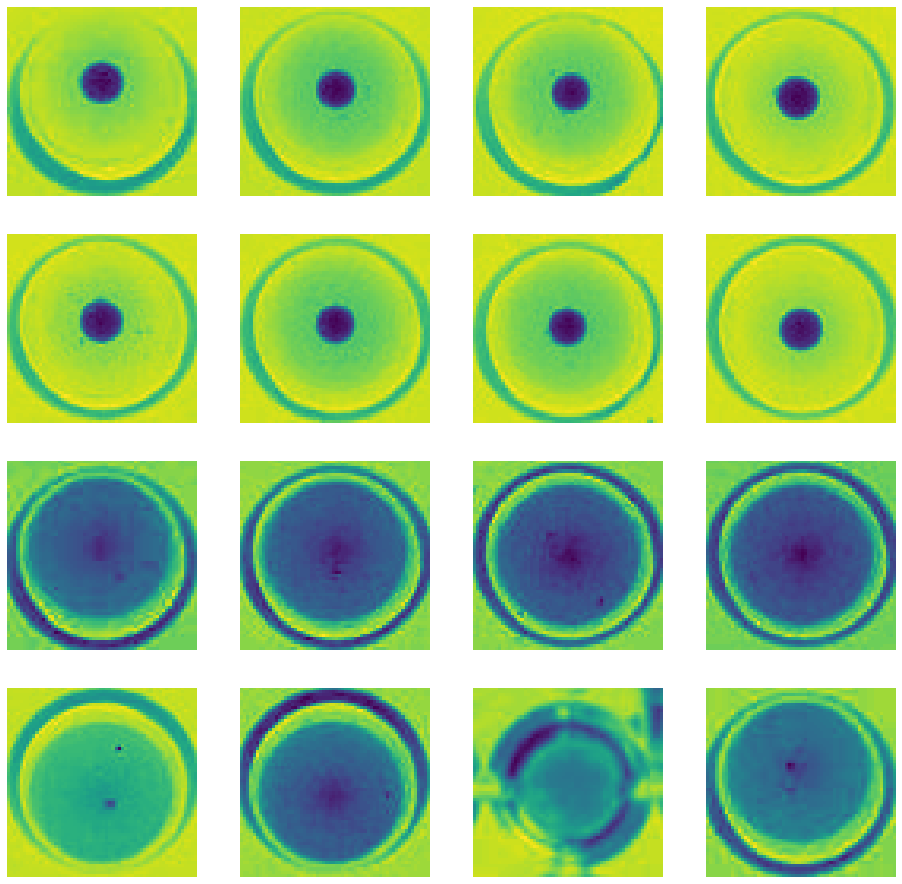

In [5]:
%matplotlib inline

nrows = 4
ncols = 4

pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_pos_pix = [os.path.join(train_pos_dir, fname) 
                for fname in train_pos_fnames[ pic_index-8:pic_index] 
               ]

next_neg_pix = [os.path.join(train_negs_dir, fname) 
                for fname in train_neg_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_pos_pix+next_neg_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Create model

In [6]:
model = tf.keras.models.Sequential([
    # The input shape is the desired size of the image 90x90 with 3(or 1) bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(60, 60, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('positives') and 1 for the other ('negatives')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

## Compute the graph

In [8]:
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## Early Stop

In [9]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print('\nAccuracy is high, stop training!')
            self.model.stop_training = True

callback = myCallback()

## Data preprocessing

In [10]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=6,
                                                    class_mode='binary',
                                                    target_size=(60, 60))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=6,
                                                         class_mode  = 'binary',
                                                         target_size = (60, 60))


Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


## Training

In [11]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=2,
    epochs=15,
    validation_steps=2,
    #callbacks=[callback],
    verbose=2)

Epoch 1/15
2/2 - 0s - loss: 0.9847 - accuracy: 0.8000 - val_loss: 0.6578 - val_accuracy: 0.5833
Epoch 2/15
2/2 - 0s - loss: 0.7033 - accuracy: 0.5833 - val_loss: 0.7202 - val_accuracy: 0.5000
Epoch 3/15
2/2 - 0s - loss: 0.6881 - accuracy: 0.5000 - val_loss: 0.9254 - val_accuracy: 0.4167
Epoch 4/15
2/2 - 0s - loss: 0.5384 - accuracy: 0.8000 - val_loss: 1.1858 - val_accuracy: 0.4167
Epoch 5/15
2/2 - 0s - loss: 0.7227 - accuracy: 0.5833 - val_loss: 0.6564 - val_accuracy: 0.5000
Epoch 6/15
2/2 - 0s - loss: 0.6998 - accuracy: 0.5000 - val_loss: 0.6392 - val_accuracy: 0.5833
Epoch 7/15
2/2 - 0s - loss: 0.6097 - accuracy: 0.6667 - val_loss: 0.6887 - val_accuracy: 0.5000
Epoch 8/15
2/2 - 0s - loss: 0.5679 - accuracy: 0.6667 - val_loss: 0.5873 - val_accuracy: 0.5833
Epoch 9/15
2/2 - 0s - loss: 0.8000 - accuracy: 0.6667 - val_loss: 0.6079 - val_accuracy: 0.5833
Epoch 10/15
2/2 - 0s - loss: 0.6452 - accuracy: 0.5000 - val_loss: 0.5765 - val_accuracy: 1.0000
Epoch 11/15
2/2 - 0s - loss: 0.5386 - a

## Visualize convolutions

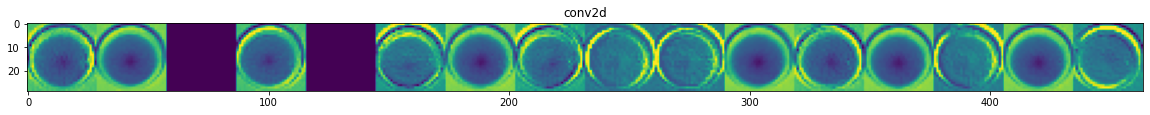

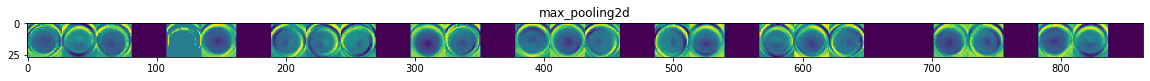

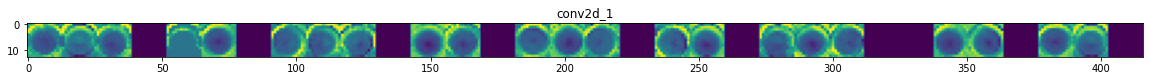

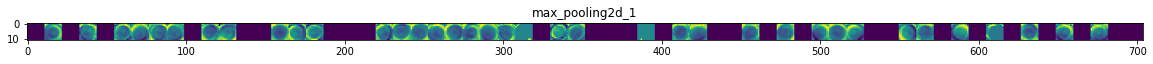

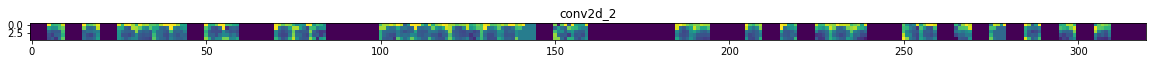

In [12]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
pos_img_files = [os.path.join(train_pos_dir, f) for f in train_pos_fnames]
neg_img_files = [os.path.join(train_negs_dir, f) for f in train_neg_fnames]

img_path = random.choice(pos_img_files + neg_img_files)
img = load_img(img_path, target_size=(60, 60))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (60, 60, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 60, 60, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

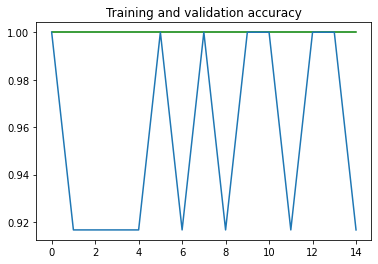

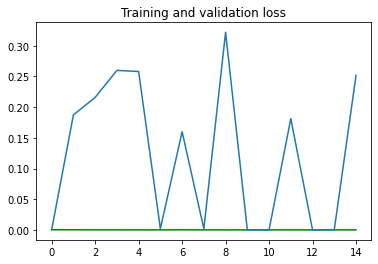

In [41]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, "g")
plt.plot(epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g')
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')